In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn import preprocessing
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import uniform, randint, loguniform
import seaborn as sns

## Visualisation

### · DataFrames

In [5]:
data = pd.read_csv("./train.csv")
data

,sample_name,device_serial,substance_form_display,measure_type_display,prod_substance,PURITY,908.1,914.3,920.5,926.7,...,1620.5,1626.6,1632.8,1639,1645.2,1651.4,1657.6,1663.8,1670,1676.2
0,11140009,M1-1000112,Homogenized Powder,Direct contact,Heroin,58.500000,0.044734,0.042720,0.041361,0.040055,...,0.003972,0.007906,0.012490,0.018123,0.025070,0.033235,0.042502,0.052237,0.061383,0.068823
1,22.0401-P002.02,M1-1000109,Non homogenized powder,Direct contact,Heroin,18.600000,0.063695,0.056980,0.050080,0.043339,...,0.093002,0.099668,0.108805,0.117120,0.121947,0.125137,0.128688,0.133501,0.138187,0.140248
2,22.0117-P001.02,M1-1000100,Non homogenized powder,Direct contact,Heroin,19.881719,0.050358,0.044910,0.039148,0.033730,...,0.083369,0.090485,0.100462,0.109033,0.113411,0.117053,0.121665,0.128366,0.134636,0.136961
3,20.0163-P009,N1-00196,Unspecified,Direct contact,Heroin,52.500000,0.525050,0.520434,0.517187,0.516377,...,0.357223,0.370060,0.386062,0.404460,0.425567,0.450527,0.479066,0.508943,0.539349,0.564486
4,19.0286-P005,N1-00196,Unspecified,Direct contact,Heroin,48.900000,0.479365,0.467401,0.456680,0.446148,...,0.350973,0.366094,0.384536,0.405034,0.426582,0.450564,0.477045,0.504142,0.531764,0.553650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,22.0267-P001.01,M1-1000100,Homogenized Powder,Direct contact,Heroin,10.100000,0.107930,0.103983,0.100068,0.096422,...,0.133917,0.138535,0.145144,0.151008,0.153738,0.155602,0.158525,0.163138,0.167623,0.169048
1296,11060000,M1-1000144,Homogenized Powder,Direct contact,Heroin,44.900000,0.040564,0.041559,0.042435,0.043870,...,-0.007995,-0.004902,-0.001237,0.003390,0.009303,0.016472,0.023843,0.031736,0.039568,0.046056
1297,22.0368-P002,M1-1000130,Homogenized Powder,Direct contact,Heroin,53.400000,0.106459,0.108084,0.109983,0.109541,...,0.052178,0.056051,0.060666,0.066257,0.073435,0.083057,0.094621,0.106288,0.117307,0.126626
1298,22.0342-P002.04,M1-1000109,Homogenized Powder,Direct contact,Heroin,13.600000,0.075628,0.068853,0.062538,0.056079,...,0.094620,0.101527,0.111090,0.119861,0.124868,0.128340,0.132605,0.138737,0.144825,0.148246


In [7]:
substances_pure = pd.read_csv("./substances.csv")
substances_pure

,substance,908.1,914.294,920.489,926.683,932.877,939.072,945.266,951.46,957.655,...,1620.451,1626.645,1632.839,1639.034,1645.228,1651.423,1657.617,1663.811,1670.006,1676.2
0,caffeine,0.062871,0.058017,0.052740,0.047231,0.041154,0.034631,0.029951,0.026841,0.025225,...,0.073463,0.082854,0.092944,0.102145,0.109443,0.115446,0.120512,0.126134,0.132459,0.137083
1,caffeine,0.061273,0.055883,0.050773,0.045217,0.039289,0.032959,0.027978,0.024919,0.023373,...,0.071352,0.080701,0.090736,0.099872,0.107126,0.113071,0.118058,0.123617,0.129854,0.134493
2,caffeine,0.062304,0.057221,0.052155,0.046489,0.040637,0.034412,0.029569,0.026437,0.025019,...,0.073347,0.082623,0.092594,0.101696,0.108913,0.114799,0.119885,0.125517,0.131766,0.136403
3,cocaine,0.051042,0.046877,0.042527,0.037775,0.032997,0.027196,0.023328,0.020364,0.018992,...,0.058376,0.065964,0.074228,0.081853,0.088030,0.093213,0.097616,0.102603,0.108232,0.112403
4,cocaine,0.053617,0.049345,0.045184,0.040282,0.035660,0.030104,0.026056,0.023729,0.022281,...,0.062409,0.069975,0.078218,0.085863,0.092000,0.097120,0.101611,0.106617,0.112249,0.116342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,4-FA,0.190973,0.176500,0.164308,0.151658,0.139436,0.128963,0.121227,0.116066,0.113162,...,0.246995,0.248058,0.251385,0.256762,0.263248,0.270890,0.279460,0.287762,0.294541,0.299701
1428,4-FA,0.271019,0.258035,0.247723,0.236982,0.226175,0.216771,0.210430,0.205678,0.203691,...,0.325009,0.326270,0.329524,0.334639,0.340574,0.347348,0.355599,0.363368,0.369503,0.374225
1429,4-FA,0.402637,0.391007,0.379815,0.369986,0.359385,0.350343,0.343034,0.338897,0.336415,...,0.435199,0.436331,0.439298,0.444223,0.449990,0.456891,0.463066,0.469699,0.475373,0.479728
1430,4-FA,0.272661,0.258039,0.245170,0.232466,0.220305,0.209469,0.202166,0.197060,0.194449,...,0.313074,0.314111,0.317441,0.322834,0.329212,0.337036,0.344704,0.352165,0.358930,0.364226


### · Plots

##### Count of each form of display

<Axes: xlabel='count', ylabel='substance_form_display'>

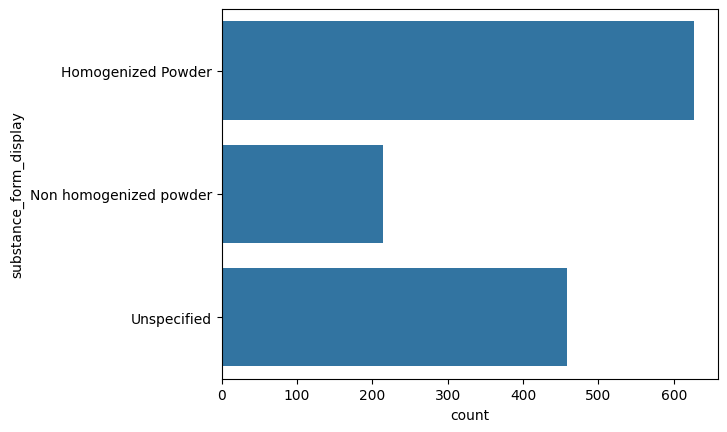

In [ ]:
sns.countplot(data['substance_form_display'])

##### Count of each device serial

<Axes: xlabel='count', ylabel='device_serial'>

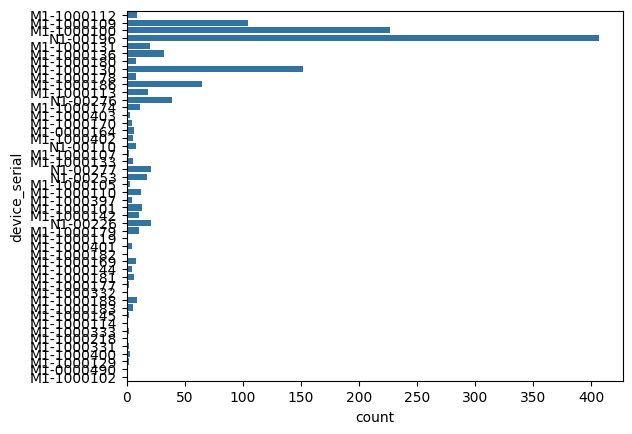

In [ ]:
sns.countplot(data['device_serial'])

##### Proportion of each purity

<Axes: xlabel='PURITY', ylabel='Density'>

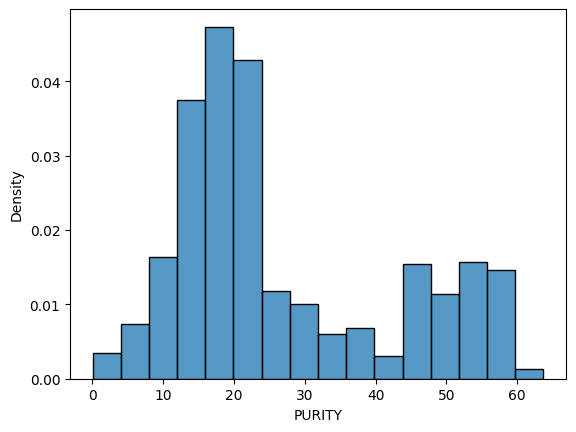

In [ ]:
sns.histplot(data['PURITY'], stat='density')

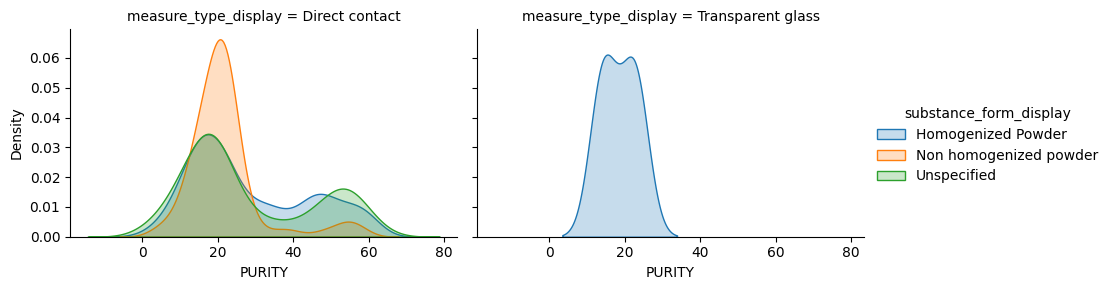

In [13]:
g = sns.FacetGrid(data, col = 'measure_type_display', hue = 'substance_form_display', aspect= 1.5)
g.map(sns.kdeplot, 'PURITY', fill = True)
g.add_legend()


##### Intervals of purity depending on the substance form display

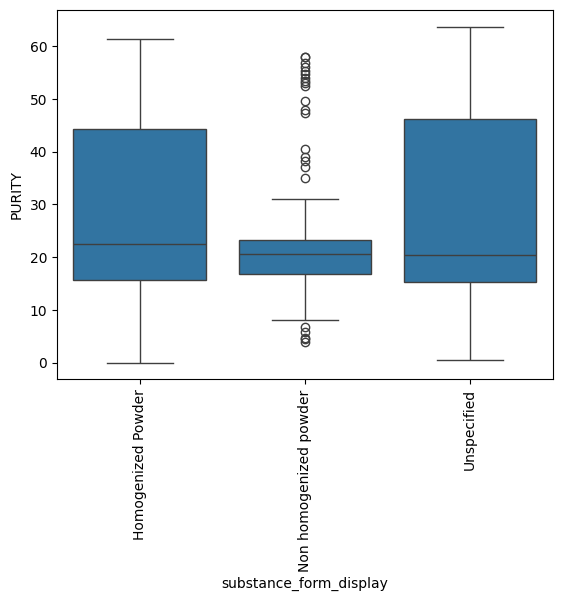

In [ ]:
ax = sns.boxplot(y = 'PURITY', x = 'substance_form_display', data = data, orient = 'v')
ax.tick_params(axis='x', rotation=90)

##### Heatmap of correlation between features

<Axes: >

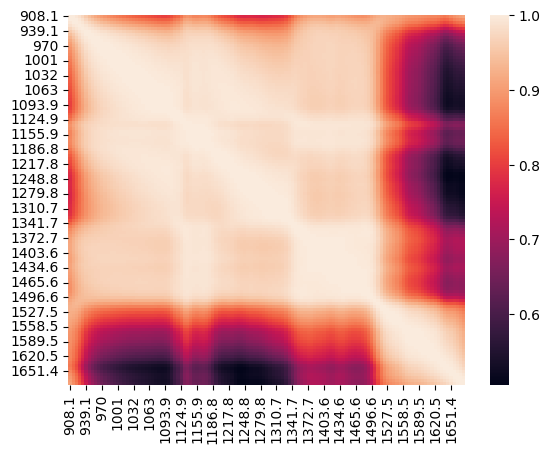

In [ ]:
sns.heatmap(data.iloc[:, 6:].corr())

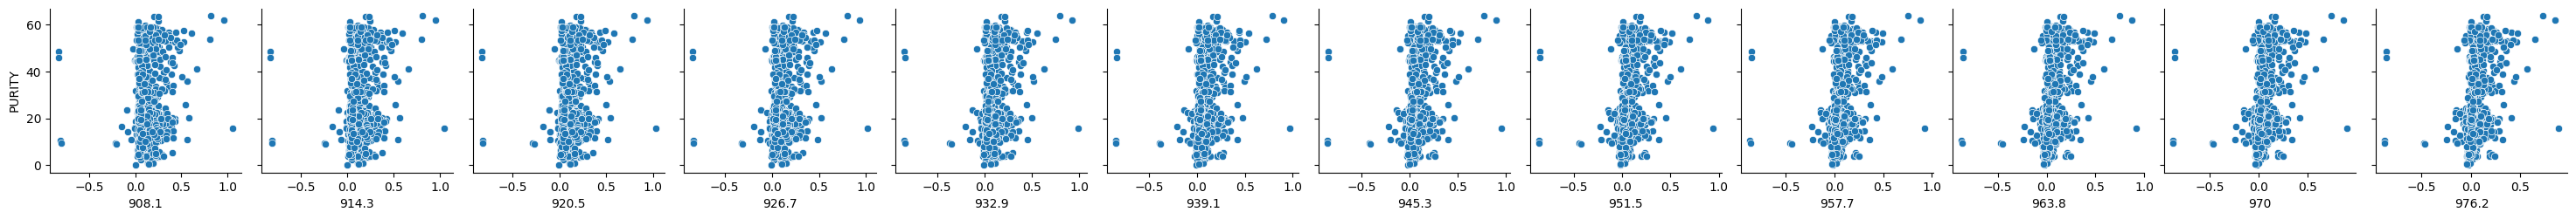

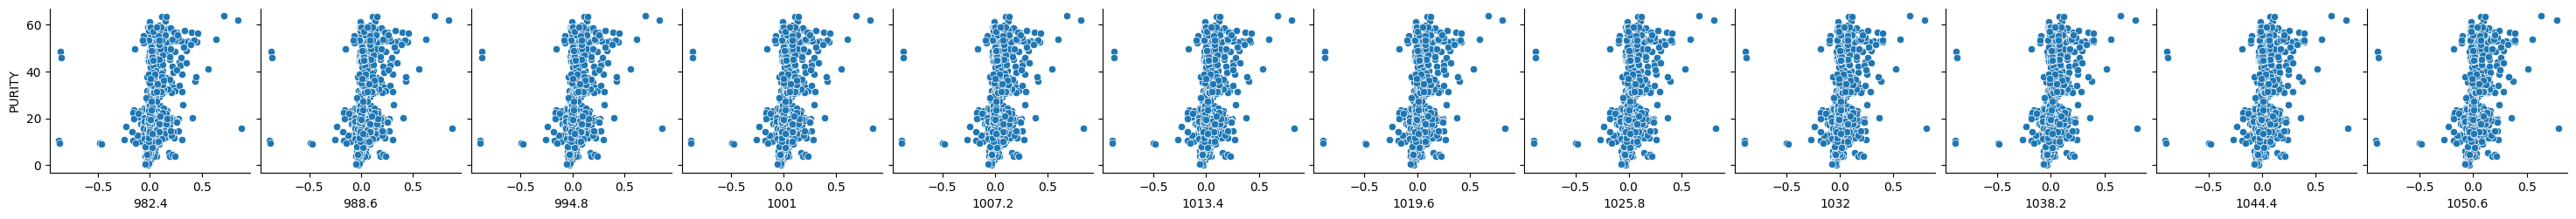

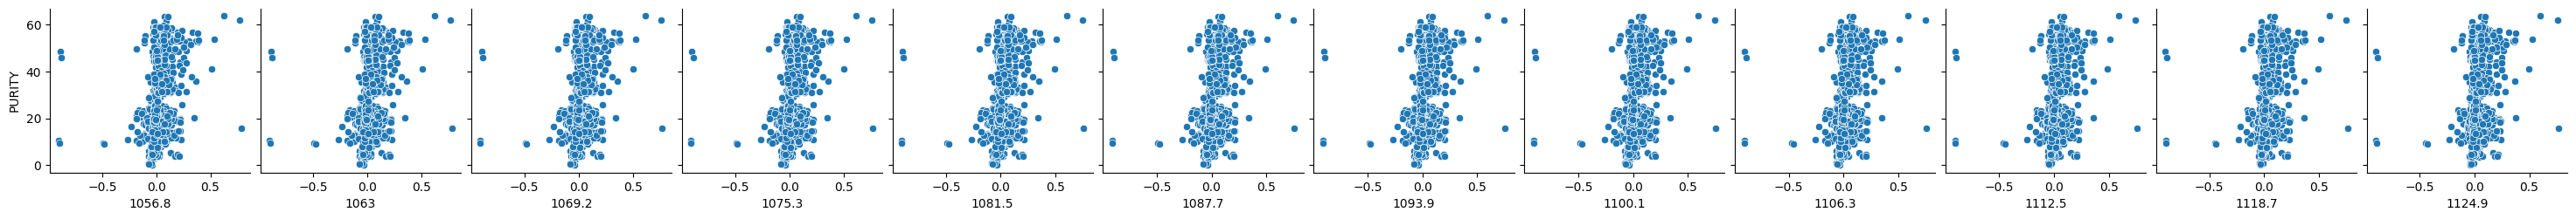

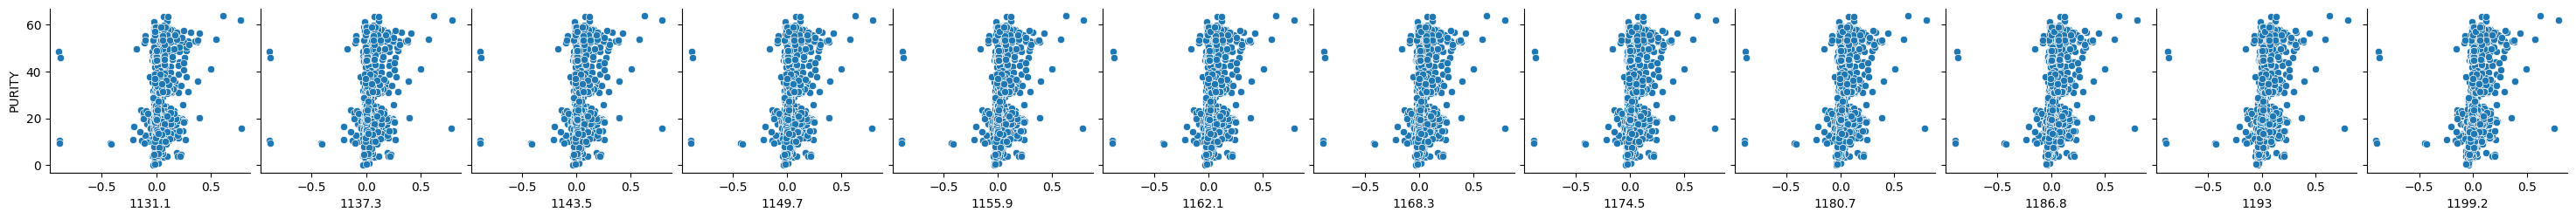

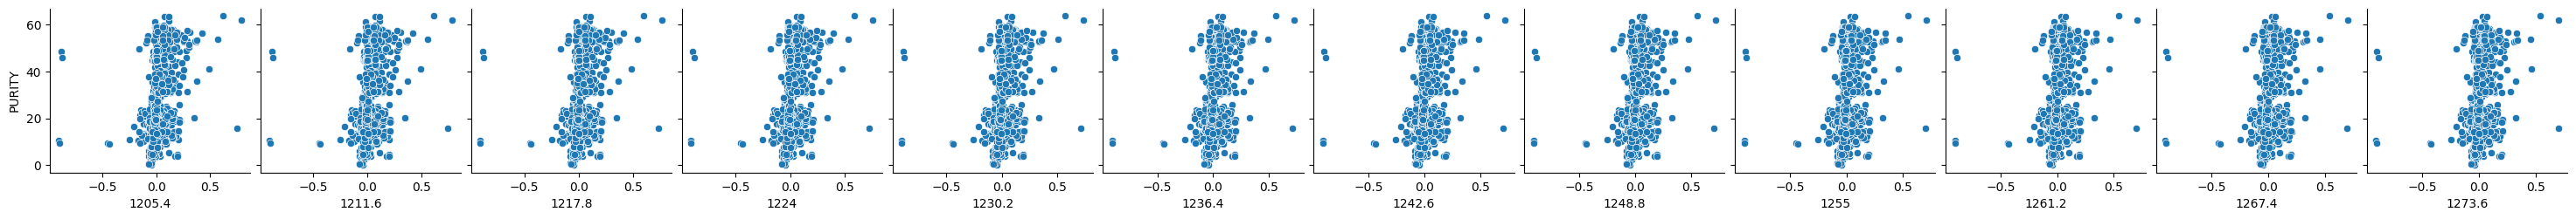

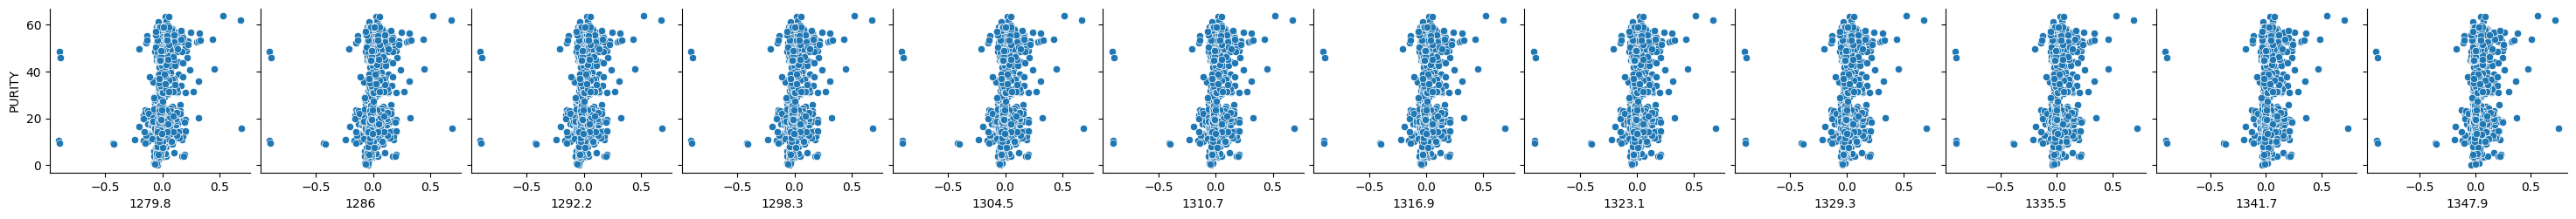

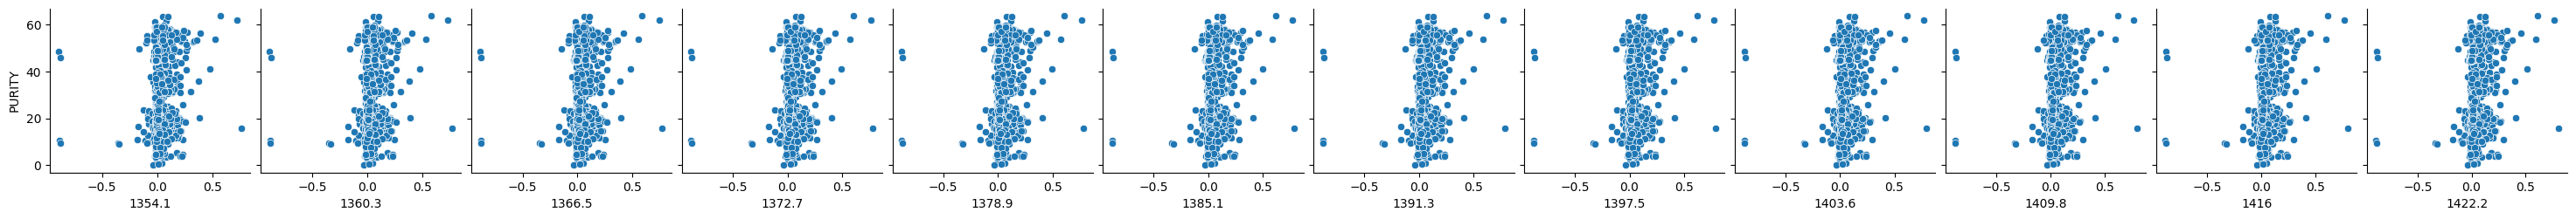

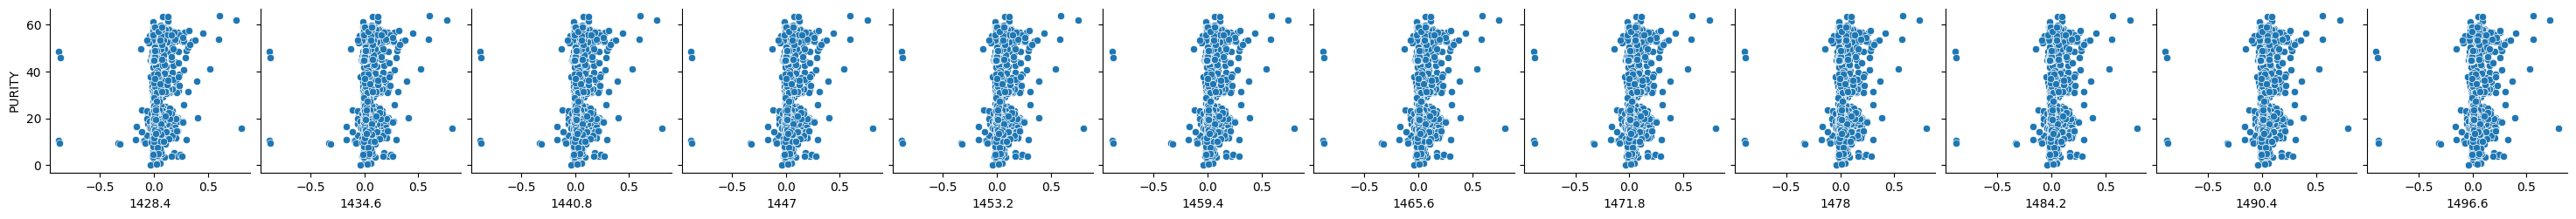

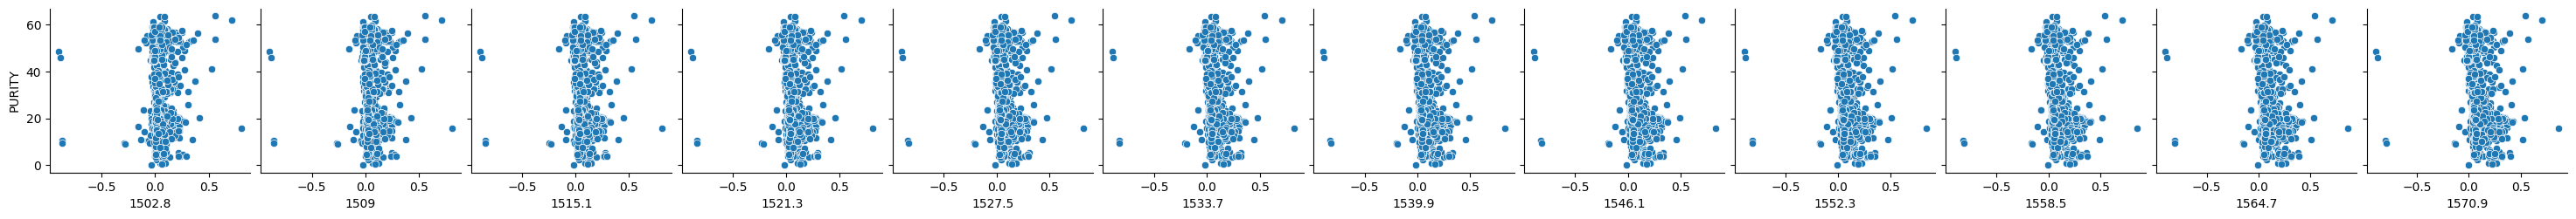

In [18]:
n = 0
for i in range (1, 10):
    sns.pairplot(data=data, x_vars= data.iloc[:, 6 + n :6 + i*12].columns.values, y_vars = 'PURITY')
    n = i*12

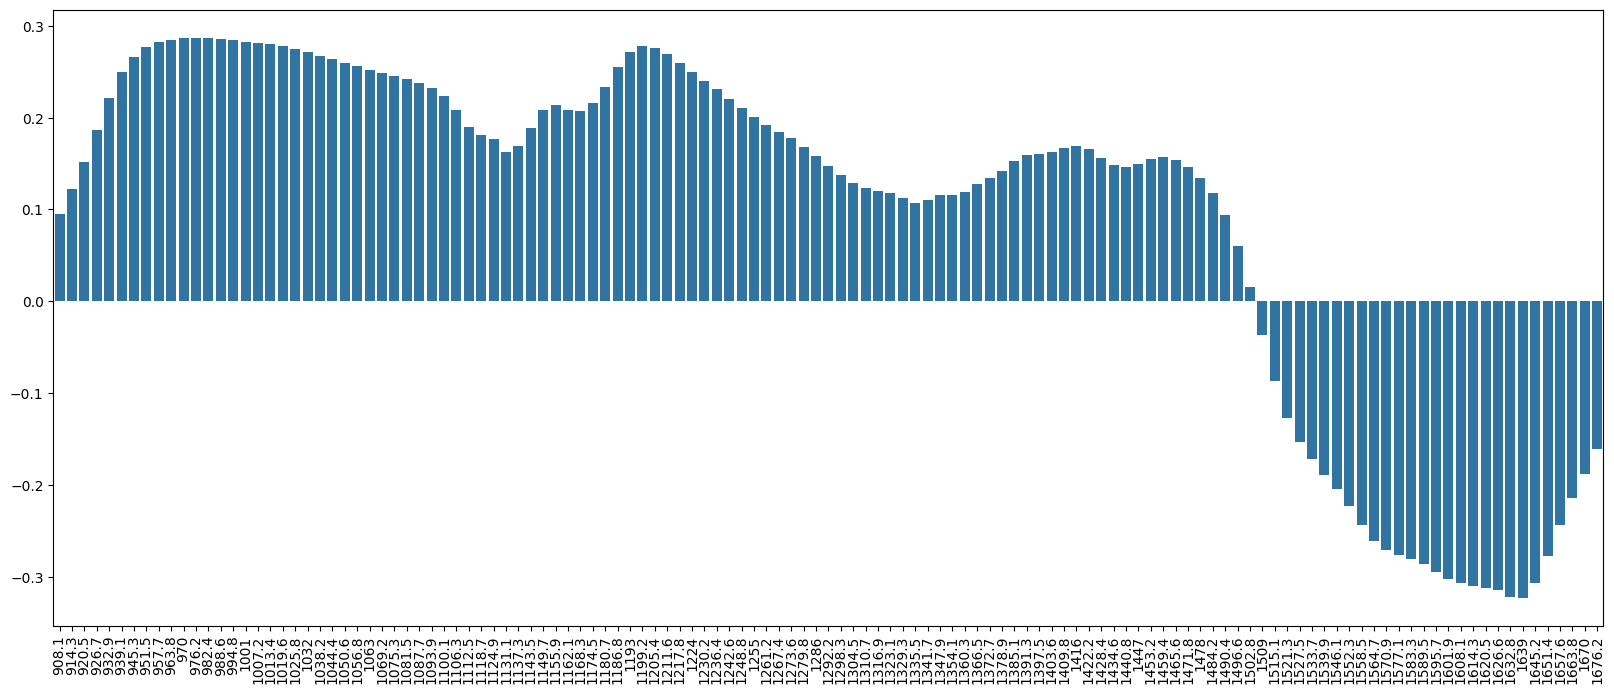

In [6]:
corrwithpurity = data.iloc[:, 6:].corrwith(data['PURITY'])
plt.figure(figsize=(20,8))
ax = sns.barplot(data = corrwithpurity)
ax.tick_params(axis='x', rotation=90)

<Axes: xlabel='count', ylabel='substance'>

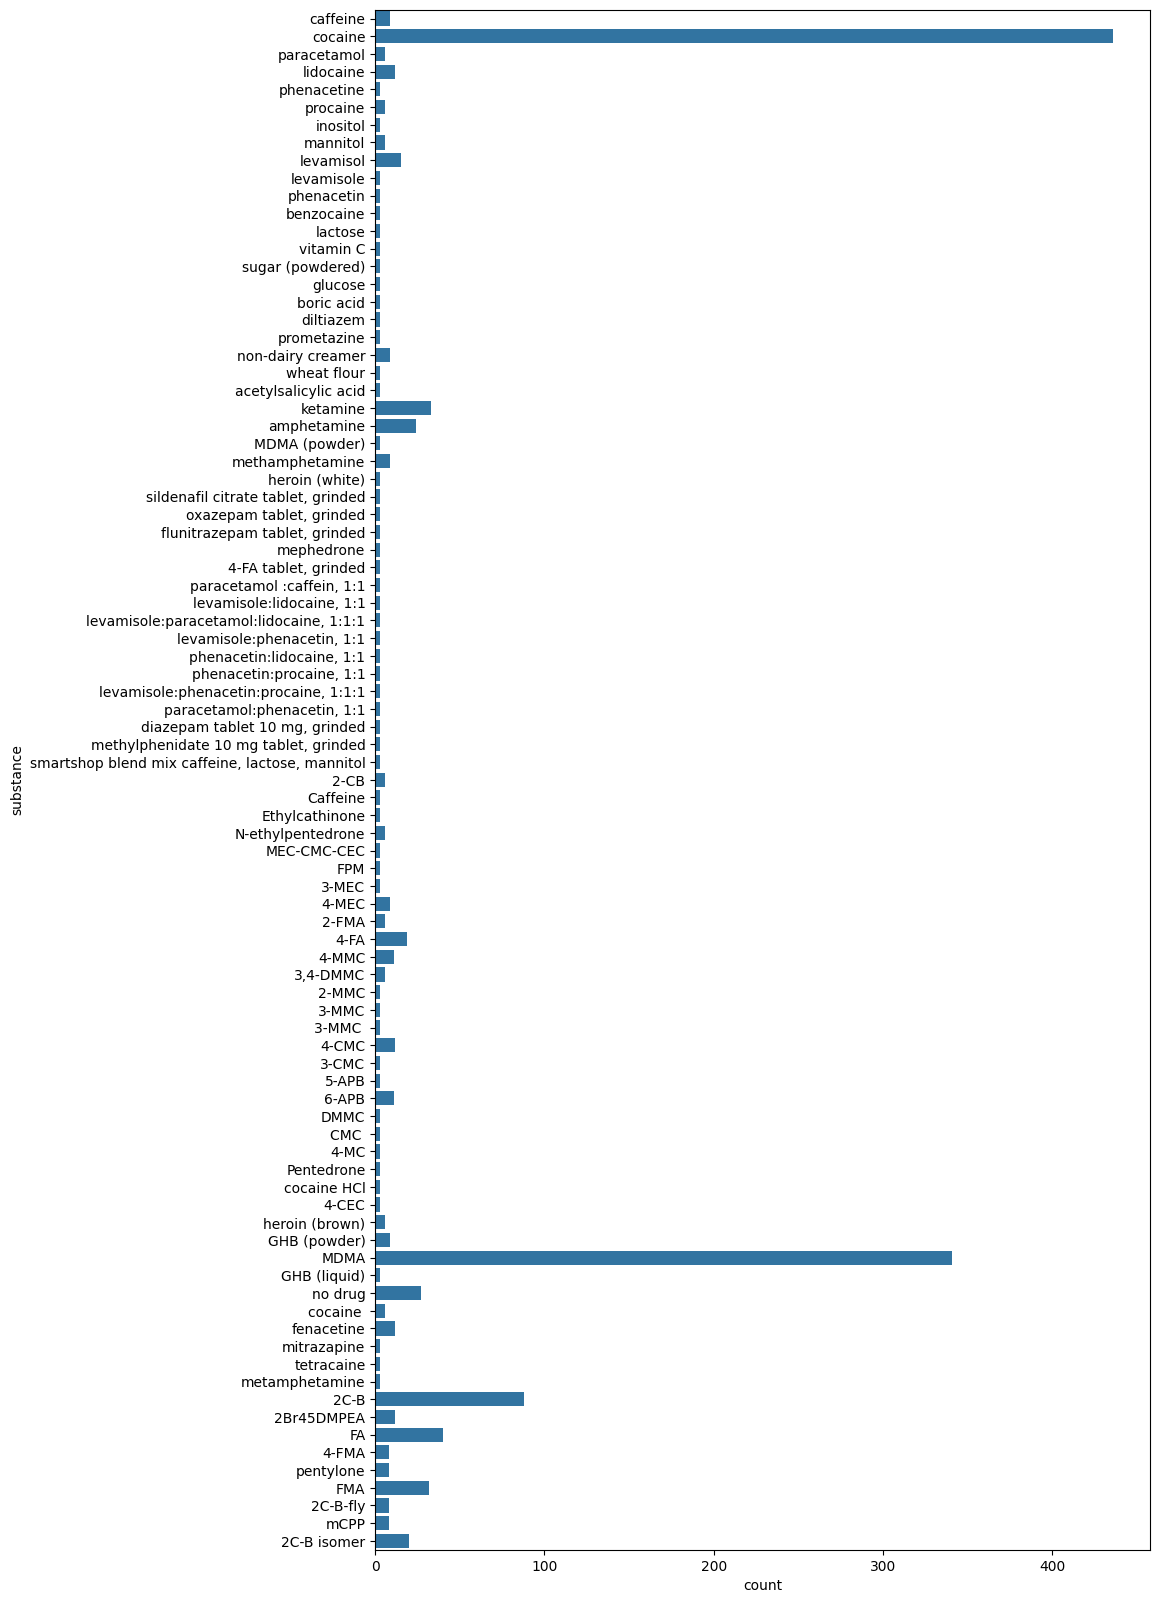

In [8]:
plt.figure(figsize=(10,20))
sns.countplot(substances_pure['substance'])

## Preprocessing

### · Linear

In [5]:
# Retrieve the data
data = pd.read_csv("./train.csv")
subspures = pd.read_csv("./substances.csv")
pure_heroin = subspures[(subspures['substance'] == 'heroin (white)') | (subspures["substance"]=="heroin (brown)")]

# Create new features by multiplying the data with the pure heroin
distances = cdist(data.iloc[:,6:].to_numpy(), pure_heroin.iloc[:, 1:].to_numpy(), metric = 'euclidean')
dist_her = pd.DataFrame(distances, index = data.iloc[:,6:].index, columns=pure_heroin.iloc[:,1:].index)
data_new_features2 = data.iloc[:, 6:].values.dot(subspures.iloc[:,1:].values.T)

# Split the data
X = data_new_features2
y = data['PURITY']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

### · Non-linear

In [6]:
#Retrieve the data
data_train = pd.read_csv("./train.csv")
data_test = pd.read_csv("./test.csv")
X_train = data_train.iloc[:, 6:]
X_test = data_test.iloc[:, 5:]

y = data_train["PURITY"]/100

# Standardize the data
standardizer = StandardScaler()
X_st = standardizer.fit_transform(X_train)

# Perform PCA 
pca = PCA(16)
pca.fit(X_st)
X_pca = pca.transform(X_st)

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).reshape(-1, 1)

# Standardize and perform PCA on the test data
X_st = standardizer.transform(X_test)
X_pca = pca.transform(X_st)
X_test_tensor = torch.tensor(X_pca, dtype=torch.float32)


## Linear Model

In [ ]:
model = Ridge() #ridge regressor model
param_grid = {'alpha': np.logspace(-7, 0, 100)} #hyperparamater alpha


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)


mach1 = grid_search.best_estimator_ #find the best model
mach1.fit(X_train, y_train) 
predictions = mach1.predict(X_valid)

#Plot the RMSE as a function of lambda
plt.figure()
plt.scatter(np.logspace(-7, 0, 100), np.sqrt(-grid_search.cv_results_['mean_test_score']))
plt.xlabel("lambda")
plt.ylabel("RMSE")
plt.xscale("log")
plt.show()


y_pred1 = mach1.predict(X_train)
y_pred2 = mach1.predict(X_valid)
train_score = np.mean(np.abs(y_pred1-y_train<=5))
test_score = np.mean(np.abs(y_pred2-y_valid<=5))
print("Train score ridge :", train_score)
print("Test score ridge :", test_score)

## Non-linear model

In [ ]:
# Define the FeedForwardNN class
class FeedForwardNN(nn.Module):

    def __init__(self, input_size, lin_layer_sizes,
                 outpout_size, lin_layer_dropouts, activation):
        
        super().__init__()
        
        if activation == 0:
            self.activation = nn.ReLU()
        elif activation == 1:
            self.activation = nn.SiLU()
        elif activation == 2:
            self.activation = nn.Tanh()
        elif activation == 3:
            self.activation = nn.LeakyReLU()

        # Linear Layers
        first_lin_layer = nn.Linear(input_size, lin_layer_sizes[0])
    
        self.lin_layers = nn.ModuleList([first_lin_layer] + [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1]) for i in range(len(lin_layer_sizes) - 1)])
      
        # Output Layer
        self.outpout_layer = nn.Linear(lin_layer_sizes[-1], outpout_size)
    
        # Dropout Layers
        self.dropout_layers = nn.ModuleList([nn.Dropout(rate) for rate,size in zip(lin_layer_dropouts,lin_layer_sizes)])

    def forward(self, x):
  
        for lin_layer, dropout_layer in zip(self.lin_layers, self.dropout_layers):

            x = lin_layer(x)
        
            x = self.activation(x)

            x = dropout_layer(x)
      
        x = self.outpout_layer(x)
        x = nn.Sigmoid()(x)
    
        return x
    
# Define the NeuralNetRegressor
class NeuralNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, random_state, eta=0.001, max_epochs=100, batch=10, lin_layer_sizes = [50, 50],
                 outpout_size = 1, lin_layer_dropouts = [0.4, 0.4], activation = 0):
        self.input_size = input_size
        self.random_state = random_state
        self.eta = eta
        self.max_epochs = max_epochs
        self.batch = batch
        self.lin_layer_sizes = lin_layer_sizes
        self.outpout_size = outpout_size
        self.lin_layer_dropouts = lin_layer_dropouts
        self.activation = activation
        self.model = FeedForwardNN(input_size, lin_layer_sizes,
                 outpout_size, lin_layer_dropouts, activation)
        self.criterion = nn.L1Loss()
    
    def fit(self, X, y, do_print=False):
        optimizer = optim.Adam(self.model.parameters(), lr=self.eta)
        X_tensor = torch.tensor(X).clone().detach().float()
        y_tensor = torch.tensor(y).clone().detach().float()
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch, shuffle=True)
        self.model.train()
        
        # Training loop
        for epoch in range(self.max_epochs):
            epoch_loss = 0.0
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()  # Reset gradients
                outputs = self.model(batch_X)  # Forward pass
                loss = self.criterion(outputs, batch_y)  # Compute loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update parameters
                epoch_loss += loss.item()
            if do_print:
                print(f"Epoch {epoch+1}/{self.max_epochs}, Loss: {epoch_loss / len(dataloader)}")
        return self
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor).flatten()
        return outputs.numpy()
    
    def parameters(self):
        return self.model.parameters()
    
# Initialize the model
seed = 43
np.random.seed(seed)
torch.manual_seed(seed)

input_size = X_train_tensor.shape[1]
net = NeuralNetRegressor(input_size=input_size, random_state=seed)

# Define the parameters for GridSearch
params_dist = {
    'eta': loguniform(1e-4, 1e-1),
    'max_epochs': randint(50, 150),
    'batch': randint(32, 70),
    'lin_layer_sizes': [[randint.rvs(32, 128) for _ in range(randint.rvs(1, 4))]],  # Taille de 1 à 4 couches, entre 32 et 128 neurones par couche
    'lin_layer_dropouts': [[uniform.rvs(0, 0.5) for _ in range(randint.rvs(1, 4))]],  # Dropout entre 0 et 0.5 pour chaque couche
    'activation': randint(0, 4),
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(net, params_dist, refit=True, cv=5, random_state=seed, scoring='neg_mean_squared_error', verbose=0)

# Train the model with the best hyperparameters
random_grid_result = random_search.fit(X_train_tensor, y_train_tensor)
nouveau_model = random_grid_result.best_estimator_

print("Best MSE: %f using %s" % (random_grid_result.best_score_, random_grid_result.best_params_))

y_pred = nouveau_model.predict(X_valid_tensor)
y_pred_train = nouveau_model.predict(X_train_tensor)
predictions = nouveau_model.predict(X_test_tensor)*100

# Verify that there are no NaN values in the predictions
print("y_pred contains NaN:", np.isnan(y_pred).any())

# Calculater the loss
mse = np.mean(((y_pred - y_valid)*100)**2)
print("MSE :", mse)

# Calculate the t_score
train_score = np.mean(np.abs((y_pred_train-y_train)*100<=5))
test_score = np.mean(np.abs((y_pred-y_valid)*100<=5))
print("t_score test :", train_score)
print("t_score train :", test_score)

ids = np.arange(1, len(predictions) + 1)

# Create a DataFrame for the output
output_df = pd.DataFrame({
    'ID': ids,
    'PURITY': predictions
})

# Save the DataFrame to a CSV file
output_df.to_csv('predictions.csv', index=False) 